In [2]:
import gym
env = gym.make('MountainCar-v0', render_mode = 'rgb_array')

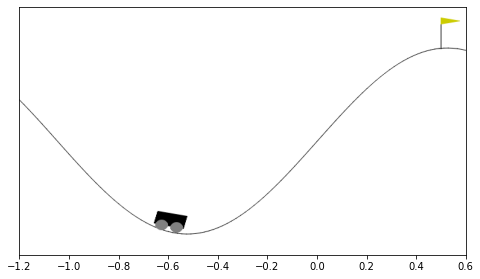

In [4]:
import matplotlib.pyplot as plt

env.reset()
frame = env.render()

fig, ax = plt.subplots(figsize=(8, 6))
ax.axes.yaxis.set_visible(False)
ax.imshow(frame, extent=[env.min_position, env.max_position, 0, 1])

In [5]:
# Action space
# 0 Accelerate to the left
# 1 Don't accelerate
# 2 Accelerate to the right

print("Action Space {}".format(env.action_space))

Action Space Discrete(3)


In [6]:
# The state consists of 2 numbers:
# - Car's position, from -1.2 to 0.6
# - Car's velocity, from -0.07 to 0.07
print("State Space {}".format(env.observation_space))

print(f'Position ranges from {env.min_position} to {env.max_position}')
print(f'Velocity ranges from {-env.max_speed} to {env.max_speed}')

State Space Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Position ranges from -1.2 to 0.6
Velocity ranges from -0.07 to 0.07


In [7]:
import numpy as np
import random

class SarsaAgent:

    def __init__(self, env, learning_rate, discount_factor):

        self.env = env
        self.q_table = self._init_q_table()

        # hyper-parameters
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

    def _init_q_table(self) -> np.array:
        """
        Return numpy array with 3 dimensions.
        The first 2 dimensions are the state components, i.e. position, speed.
        The third dimension is the action.
        """
        # discretize state space from a continuous to discrete
        high = self.env.observation_space.high
        low = self.env.observation_space.low
        n_states = (high - low) * np.array([10, 100])
        n_states = np.round(n_states, 0).astype(int) + 1

        # table with q-values: n_states[0] * n_states[1] * n_actions
        return np.zeros([n_states[0], n_states[1], self.env.action_space.n])

    def _discretize_state(self, state):
        min_states = self.env.observation_space.low
        state_discrete = (state - min_states) * np.array([10, 100])
        return np.round(state_discrete, 0).astype(int)

    def get_action(self, state, epsilon=None):
        """
            As Sarsa learns from the action to be taken 
            in the next state to which the agent passes 
            with the selected action, the stochastic process 
            of exploration and exploitation is found in 
            this function. 
        """
        if epsilon and random.uniform(0, 1) < epsilon:
            # Explore action space
            action = self.env.action_space.sample()
        else:
            # Exploit learned values
            state_discrete = self._discretize_state(state)
            action = np.argmax(self.q_table[state_discrete[0], state_discrete[1]])
        
        return action

    def update_parameters(self, state, action, reward, next_state, epsilon):
        """
        Sarsa takes the agent's policy into account in its learning process. 
        Unlike Q-learning, which relies on previous experience in a greedy way, 
        Sarsa takes into account the agent's next decision, which is determined 
        by the agent's policy.
        """
        s = self._discretize_state(state)
        ns = self._discretize_state(next_state)
        na = self.get_action(next_state, epsilon)

        current_action = self.q_table[s[0], s[1], action]
        next_action = self.q_table[ns[0], ns[1], na]
        delta = self.learning_rate * (reward + self.discount_factor * next_action - current_action)

        self.q_table[s[0], s[1], action] += delta